# Experiment

Train a convolutional MNIST model without a class (say 0) and then evaluate on that class


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
from sklearn.metrics import classification_report, accuracy_score

2021-10-13 11:58:33.719408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Magic TF-Cuda fix
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2021-10-13 11:58:34.800235: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-13 11:58:34.800815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-13 11:58:34.847571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 11:58:34.847940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.665GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-13 11:58:34.847986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-13 11:58:34.849626: I tensorflow/stream_executor/platf

## Data

In [3]:
mnist = datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [6]:
target_class = 0
tgt_pcts = np.arange(0.0, 0.11, 0.01)
tgt_pcts = np.insert(tgt_pcts, 1, 0.001)
tgt_pcts = np.insert(tgt_pcts, 2, 0.005)
tgt_pcts = np.append(tgt_pcts, 0.5)
tgt_pcts = np.append(tgt_pcts, 1.0)
print(tgt_pcts)

[0.    0.001 0.005 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09
 0.1   0.5   1.   ]


## Model

In [7]:
def get_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=trn_x[0].shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

## Different amounts of target class points

In [8]:
%%time

histories = []
tgt_accs = []
glb_accs = []
num_includes = []

for tgt_pct in tgt_pcts:
    # Data filtering
    trn_x = np.expand_dims(x_train[y_train != target_class], axis=-1)
    trn_y = y_train[y_train != target_class]
    tst_x = np.expand_dims(x_test, axis=-1)
    tst_y = y_test
    
    trn_xt = np.expand_dims(x_train[y_train == target_class], axis=-1)
    trn_yt = y_train[y_train == target_class]
    tst_xt = np.expand_dims(x_test[y_test == target_class], axis=-1)
    tst_yt = y_test[y_test == target_class]    
    
    num_include = int(tgt_pct * trn_xt.shape[0])
    num_includes.append(num_include)
    print(
        '\nFraction: {}\n'
        'Including {} samples'
        'from the target class in training set'.format(tgt_pct, num_include)
    )

    trn_x = np.concatenate((trn_x, trn_xt[:num_include]))
    trn_xt = trn_xt[num_include:]
    trn_y = np.concatenate((trn_y, trn_yt[:num_include]))
    trn_yt = trn_yt[num_include:]
    
    print(
        'Train: {} - {}\n'
        'Test: {} - {}\n'
        'Train tgt: {} - {}\n'
        'Test tgt: {} - {}\n'.format(
            trn_x.shape,
            trn_y.shape,
            tst_x.shape, 
            tst_y.shape,
            trn_xt.shape,
            trn_yt.shape,
            tst_xt.shape,
            tst_yt.shape
        )
    )
    
    # Model
    model = get_model()
    
    history = model.fit(trn_x, trn_y, epochs=10, validation_data=(trn_xt, trn_yt))
    histories.append(history)
    
    tgt_pred = np.argmax(model.predict(tst_xt), axis=-1)
    tgt_acc = accuracy_score(tst_yt, tgt_pred)
    tgt_accs.append(tgt_acc)
    
    glb_pred = np.argmax(model.predict(tst_x), axis=-1)
    glb_acc = accuracy_score(tst_y, glb_pred)
    glb_accs.append(glb_acc)
    
    del model 


Fraction: 0.0
Including 0 samplesfrom the target class in training set
Train: (54077, 28, 28, 1) - (54077,)
Test: (10000, 28, 28, 1) - (10000,)
Train tgt: (5923, 28, 28, 1) - (5923,)
Test tgt: (980, 28, 28, 1) - (980,)



2021-10-13 11:58:35.733919: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-13 11:58:35.734074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 11:58:35.734351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.665GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-13 11:58:35.734373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-13 11:58:35.734393: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-13 11:58:35.734403: I tensorflow/stream_executor/pl

Epoch 1/10


2021-10-13 11:58:36.175002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-13 11:58:36.472451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-13 11:58:36.474137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1690/1690 [==============================] - 5s 2ms/step - loss: 0.3673 - accuracy: 0.8805 - val_loss: 10.4938 - val_accuracy: 0.0000e+00
Epoch 2/10
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0467 - accuracy: 0.9852 - val_loss: 11.2432 - val_accuracy: 0.0000e+00
Epoch 3/10
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0313 - accuracy: 0.9899 - val_loss: 11.4103 - val_accuracy: 0.0000e+00
Epoch 4/10
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 12.5849 - val_accuracy: 0.0000e+00
Epoch 5/10
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0183 - accuracy: 0.9945 - val_loss: 13.3896 - val_accuracy: 0.0000e+00
Epoch 6/10
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 13.7893 - val_accuracy: 0.0000e+00
Epoch 7/10
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 15.

1696/1696 [==============================] - 3s 2ms/step - loss: 0.3371 - accuracy: 0.8905 - val_loss: 0.3136 - val_accuracy: 0.9017
Epoch 2/10
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0486 - accuracy: 0.9839 - val_loss: 0.1974 - val_accuracy: 0.9417
Epoch 3/10
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0310 - accuracy: 0.9903 - val_loss: 0.2733 - val_accuracy: 0.9154
Epoch 4/10
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.1837 - val_accuracy: 0.9462
Epoch 5/10
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.3677 - val_accuracy: 0.9006
Epoch 6/10
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.2026 - val_accuracy: 0.9405
Epoch 7/10
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0120 - accuracy: 0.9955 - val_loss: 0.1942 - val_accuracy: 0.9426
Epo

1705/1705 [==============================] - 3s 2ms/step - loss: 0.3670 - accuracy: 0.8806 - val_loss: 0.1734 - val_accuracy: 0.9450
Epoch 2/10
1705/1705 [==============================] - 3s 2ms/step - loss: 0.0506 - accuracy: 0.9838 - val_loss: 0.2342 - val_accuracy: 0.9305
Epoch 3/10
1705/1705 [==============================] - 3s 2ms/step - loss: 0.0346 - accuracy: 0.9891 - val_loss: 0.2035 - val_accuracy: 0.9376
Epoch 4/10
1705/1705 [==============================] - 3s 2ms/step - loss: 0.0258 - accuracy: 0.9915 - val_loss: 0.1324 - val_accuracy: 0.9637
Epoch 5/10
1705/1705 [==============================] - 3s 2ms/step - loss: 0.0188 - accuracy: 0.9936 - val_loss: 0.1550 - val_accuracy: 0.9552
Epoch 6/10
1705/1705 [==============================] - 3s 2ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.0727 - val_accuracy: 0.9789
Epoch 7/10
1705/1705 [==============================] - 3s 2ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.2245 - val_accuracy: 0.9371
Epo

## Visualizations

In [28]:
val_accs = [h.history['val_accuracy'][-1] for h in histories[:-1]]

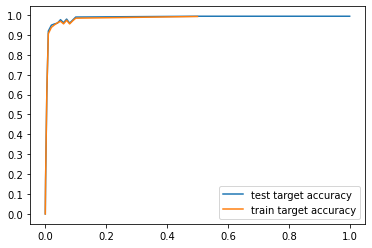

In [39]:
plt.plot(tgt_pcts, tgt_accs)
plt.plot(tgt_pcts[:-1], val_accs)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(['test target accuracy', 'train target accuracy'], loc='lower right')
plt.show()

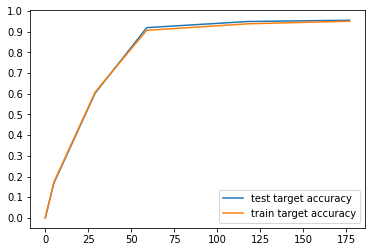

In [40]:
plt.plot(num_includes[:6], tgt_accs[:6])
plt.plot(num_includes[:6], val_accs[:6])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(['test target accuracy', 'train target accuracy'], loc='lower right')
plt.show()